# NEI (Noisy Expected Improvement) Demo

You can also look at the Botorch implementation, but that requires a lot more understanding of code which involves Pytorch.  So I tried to put a simple example together here.

In [1]:
import numpy as np
import qmcpy as qp
from scipy.linalg import solve_triangular, cho_solve, cho_factor
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

lw = 3
ms = 8

We make some fake data and consider the sequential decision making problem of trying to optimize the function depicted below.

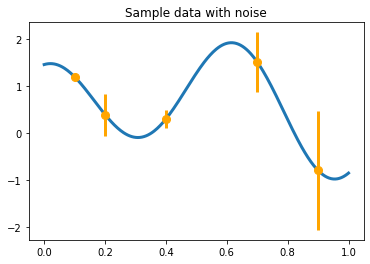

In [2]:
def yf(x):
    return np.cos(10 * x) * np.exp(.2 * x) + np.exp(-5 * (x - .4) ** 2)

xplt = np.linspace(0, 1, 300)
yplt = yf(xplt)

x = np.array([.1, .2, .4, .7, .9])
y = yf(x)
v = np.array([.001, .05, .01, .1, .4])

plt.plot(xplt, yplt, linewidth=lw)
plt.plot(x, y, 'o', markersize=ms, color='orange')
plt.errorbar(x, y, yerr=2 * np.sqrt(v), marker='', linestyle='', color='orange', linewidth=3)
plt.title('Sample data with noise');

We can build a zero mean Gaussian process model to this data, observed under noise.  Below are plots of the posterior distribution.  We use the Gaussian (square exponential) kernel as our prior covariance belief.

This kernel has a shape parameter, the Gaussian process has a global variance, which are both chosen fixed for simplicity.  The `fudge_factor` which is added here to prevent ill-conditioning for a large matrix.

Notice the higher uncertainty in the posterior in locations where the observed noise is greater.

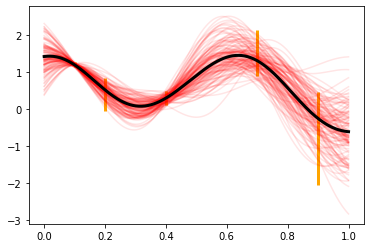

In [3]:
def gaussian_kernel(x, z, e, pv):
    return pv * np.exp(-e ** 2 * (x[:, None] - z[None, :]) ** 2)

shape_parameter = 4.1
process_variance = .9
fudge_factor = 1e-10

kernel_prior_data = gaussian_kernel(x, x, shape_parameter, process_variance)
kernel_cross_matrix = gaussian_kernel(xplt, x, shape_parameter, process_variance)
kernel_prior_plot = gaussian_kernel(xplt, xplt, shape_parameter, process_variance)

prior_cholesky = np.linalg.cholesky(kernel_prior_data + np.diag(v))
partial_cardinal_functions = solve_triangular(prior_cholesky, kernel_cross_matrix.T, lower=True)
posterior_covariance = kernel_prior_plot - np.dot(partial_cardinal_functions.T, partial_cardinal_functions)
posterior_cholesky = np.linalg.cholesky(posterior_covariance + fudge_factor * np.eye(len(xplt)))

full_cardinal_functions = solve_triangular(prior_cholesky.T, partial_cardinal_functions, lower=False)
posterior_mean = np.dot(full_cardinal_functions.T, y)

num_posterior_draws = 123
normal_draws = np.random.normal(size=(num_posterior_draws, len(xplt)))
posterior_draws = posterior_mean[:, None] + np.dot(posterior_cholesky, normal_draws.T)

plt.plot(xplt, posterior_draws, alpha=.1, color='r')
plt.plot(xplt, posterior_mean, color='k', linewidth=lw)
plt.errorbar(x, y, yerr=2 * np.sqrt(v), marker='', linestyle='', color='orange', linewidth=3);

First we take a look at the EI quantity by itself which, despite having a closed form, we will approximate using basic Monte Carlo below.  The closed form is very preferable, but not applicable in all situations.

Expected improvement is just the expectation (under the posterior distribution) of the improvement beyond the current best value.  If we were trying to maximize this function that we are studying then improvement would be defined as

$$I(x) = (Y_x|\mathcal{D} - y^*)_+,$$

the positive part of the gap between the model $Y_x|\mathcal{D}$ and the current highest value $y^*=\max\{y_1,\ldots,y_N\}$.  Since $Y_x|\mathcal{D}$ is a random variable (normally distributed because we have a Gaussian process model), we generally study the expected value of this, which is plotted below.  Written as an integral, this would look like

$$\mathrm{EI}(x) = \int_{-\infty}^\infty (y - y^*)_+\, p_{Y_x|\mathcal{D}}(y)\; \text{d}y$$

**NOTE**: This quantity is written for maximization here, but most of the literature is concerned with minimization.  I can rewrite this if needed, but the math is essentially the same.

This $EI$ quantity is referred to as an _acquisition function_, a function which defines the utility associated with sampling at a given point.  For each acquisition function, there is a balance between exploration and exploitation (as is the focus of most topics involving sequential decision making under uncertainty).

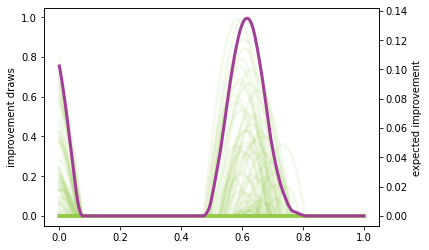

In [4]:
improvement_draws = np.fmax(posterior_draws - max(y), 0)
plt.plot(xplt, improvement_draws, alpha=.1, color='#96CA4F', linewidth=lw)
plt.ylabel('improvement draws')
ax2 = plt.gca().twinx()
ax2.plot(xplt, np.mean(improvement_draws, axis=1), color='#A23D97', linewidth=lw)
ax2.set_ylabel('expected improvement');

The NEI quantity is then computed using multiple EI computations (each using a different posterior GP draw) computed without noise.  In this computation below, I will use the closed form of EI, to speed up the computation -- it is possible to execute the same strategy as above, though.

This computation is vectorized so as to compute for multiple $x$ locations at the same time ... the algorithm from the [Facebook paper](https://projecteuclid.org/download/pdfview_1/euclid.ba/1533866666) is written for only a single location.  We are omitting the constraints aspect of their paper because the problem can be considered without that.  To define the integral, though, we need some more definitions/notation.

First, we need to define $\mathrm{EI}(x;\mathbf{y}, \mathcal{X}, \boldsymbol{\epsilon})$ to be the expected improvement at a location $x$, given the $N$ values stored in the vector $\mathbf{y}$ having been evaluated with noise $\boldsymbol{\epsilon}$ at the points $\mathcal{X}$,

$$
\mathbf{y}=\begin{pmatrix}y_1\\\vdots\\y_N\end{pmatrix},\qquad \mathcal{X}=\{\mathbf{x}_1,\ldots,\mathbf{x}_N\},\qquad \boldsymbol{\epsilon}=\begin{pmatrix}\epsilon_1\\\vdots\\\epsilon_N\end{pmatrix}.
$$

The noise is assumed to be $\epsilon_i\sim\mathcal{N}(0, \sigma^2)$ for some fixed $\sigma^2$.  The noise need not actually be homoscedastic, but it is a standard assumption.
We encapsulate this information in $\mathcal{D}=\{\mathbf{y},\mathcal{X},\boldsymbol{\epsilon}\}$.  This is omitted from the earlier notation, because the data would be fixed.

The point of NEI though is to deal with **noisy** observed values (EI, itself, is notorious for not dealing with noisy data very well).  It does this by considering a variety of posterior draws at the locations in $\mathcal{X}$.  These have distribution

$$
Y_{\mathcal{X}}|\mathcal{D}=Y_{\mathcal{X}}|\mathbf{y}, \mathcal{X}, \boldsymbol{\epsilon}\sim \mathcal{N}\left(\mathsf{K}(\mathsf{K}+\mathsf{E})^{-1}\mathbf{y}, \mathsf{K} - \mathsf{K}(\mathsf{K}+\mathsf{E})^{-1}\mathsf{K}\right),
$$

where

$$
\mathbf{k}(x)=\begin{pmatrix}K(x,x_1)\\\vdots\\K(x,x_N)\end{pmatrix},\qquad
\mathsf{K}=\begin{pmatrix}
K(x_1,x_1)&\cdots&K(x_1, x_N)\\&\vdots&\\K(x_N,x_1)&\cdots&K(x_N, x_N)
\end{pmatrix}=\begin{pmatrix}\mathbf{k}(x_1)^T\\\vdots\\\mathbf{k}(x_N)^T\end{pmatrix},\qquad
\mathsf{E}=\begin{pmatrix}\epsilon_1&&\\&\ddots&\\&&\epsilon_N\end{pmatrix}
$$

In practice, unless noise has actually been measured at each point, it would be common to simply plug in $\epsilon_1=\ldots=\epsilon_N=\sigma^2$.  The term `noisy_predictions_at_data` below is drawn from this distribution (though in a standard iid fashion, not a more awesome QMC fashion).

The EI integral, although approximated earlier using Monte Carlo, can actually be written in closed form.  We do so below to also solidify our newer notation:

$$
\mathrm{EI}(x;\mathbf{y}, \mathcal{X}, \boldsymbol{\epsilon}) = \int_{-\infty}^\infty (y - y^*)_+\, p_{Y_x|\mathbf{y}, \mathcal{X}, \boldsymbol{\epsilon}}(y)\; \text{d}y = s(z\Phi(z)+\phi(z))
$$

where $\phi$ and $\Phi$ are the standard normal pdf and cdf, and

$$
\mu=\mathbf{k}(x)^T(\mathsf{K}+\mathsf{E})^{-1}\mathbf{y},\qquad s^2 = K(x, x)-\mathbf{k}(x)^T(\mathsf{K}+\mathsf{E})^{-1}\mathbf{k}(x),\qquad z=(\mu - y^*)/s.
$$

It is very important to remember that these quantities are functions of $\mathbf{y},\mathcal{X},\boldsymbol{\epsilon}$ despite the absence of those quantities in the notation.

The goal of the NEI integral is to simulate many possible random realizations of what could actually be the truth at the locations $\mathcal{X}$ and then run a *noiseless* EI computation over each of those realizations.  The average of these outcomes is the NEI quantity.  This would look like:

$$
\mathrm{NEI}(x) = \int_{\mathbf{f}\in\mathbb{R}^N} \mathrm{EI}(x;\mathbf{f}, \mathcal{X}, 0)\, p_{Y_{\mathcal{X}}|\mathbf{y},\mathcal{X},\boldsymbol{\epsilon}}(\mathbf{f})\;\text{d}\mathbf{f}
$$

**NOTE**: There are ways to do this computation in a more vectorized fashion, so it would more likely be a loop involving chunks of MC elements at a time.  Just so you know.

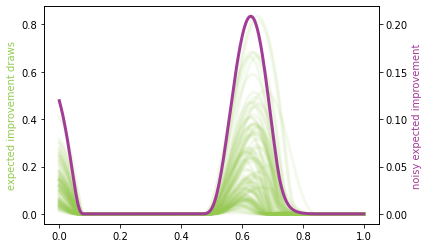

In [5]:
num_draws_at_data = 109
# These draws are done through QMC in the FB paper
normal_draws_at_data = np.random.normal(size=(num_draws_at_data, len(x)))

partial_cardinal_functions_at_data = solve_triangular(prior_cholesky, kernel_prior_data.T, lower=True)
posterior_covariance_at_data = kernel_prior_data - np.dot(partial_cardinal_functions_at_data.T, partial_cardinal_functions_at_data)
posterior_cholesky_at_data = np.linalg.cholesky(posterior_covariance_at_data + fudge_factor * np.eye(len(x)))

noisy_predictions_at_data = y[:, None] + np.dot(posterior_cholesky_at_data, normal_draws_at_data.T)

prior_cholesky_noiseless = np.linalg.cholesky(kernel_prior_data)
partial_cardinal_functions = solve_triangular(prior_cholesky_noiseless, kernel_cross_matrix.T, lower=True)
full_cardinal_functions = solve_triangular(prior_cholesky.T, partial_cardinal_functions, lower=False)
pointwise_sd = np.sqrt(np.fmax(process_variance - np.sum(partial_cardinal_functions ** 2, axis=0), 1e-100))

all_noiseless_eis = []
for draw in noisy_predictions_at_data.T:
    posterior_mean = np.dot(full_cardinal_functions.T, draw)
    
    z = (posterior_mean - max(y)) / pointwise_sd
    ei = pointwise_sd * (z * norm.cdf(z) + norm.pdf(z))
    
    all_noiseless_eis.append(ei)

all_noiseless_eis = np.array(all_noiseless_eis)

plt.plot(xplt, all_noiseless_eis.T, alpha=.1, color='#96CA4F', linewidth=lw)
plt.ylabel('expected improvement draws', color='#96CA4F')
ax2 = plt.gca().twinx()
ax2.plot(xplt, np.mean(all_noiseless_eis, axis=0), color='#A23D97', linewidth=lw)
ax2.set_ylabel('noisy expected improvement', color='#A23D97');

## Goal

What would be really great would be if we could compute integrals like the EI integral or the NEI integral using QMC. If there are opportunities to use the latest research to adaptively study tolerance and truncate, that would be absolutely amazing.

I put the NEI example up first because the FB crew has already done a great job showing how QMC can play a role.  But, as you can see, NEI is more complicated than EI, and also not yet as popular in the community (though that may change).

### Bonus stuff

Even the EI integral, which does have a closed form, might better be considered in a QMC fashion because of interesting use cases.  I'm going to reconsider the same problem from above, but here I am not looking to maximize the function -- I want to find the "level set" associated with the value $y=1$.  Below you can see how the different outcome might look.

In this case, the quantity of relevance is not exactly an integral, but it is a function of this posterior mean and standard deviation, which might need to be estimated through an integral (rather than the closed form, which we do have for a GP situation).

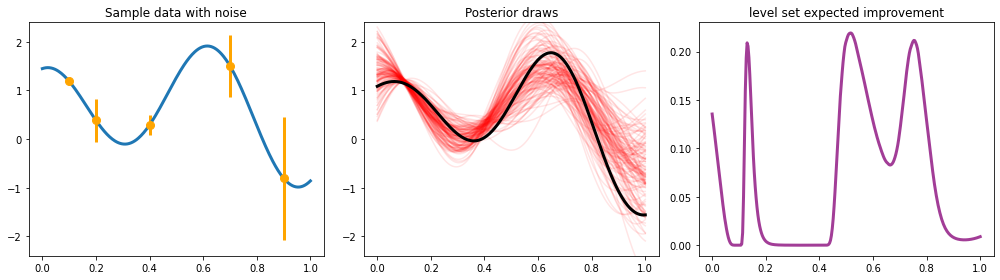

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ax = axes[0]
ax.plot(xplt, yplt, linewidth=lw)
ax.plot(x, y, 'o', markersize=ms, color='orange')
ax.errorbar(x, y, yerr=2 * np.sqrt(v), marker='', linestyle='', color='orange', linewidth=3)
ax.set_title('Sample data with noise')
ax.set_ylim(-2.4, 2.4)

ax = axes[1]
ax.plot(xplt, posterior_draws, alpha=.1, color='r')
ax.plot(xplt, posterior_mean, color='k', linewidth=lw)
ax.set_title('Posterior draws')
ax.set_ylim(-2.4, 2.4)

ax = axes[2]
posterior_mean_distance_from_1 = np.mean(np.abs(posterior_draws - 1), axis=1)
posterior_standard_deviation = np.std(posterior_draws, axis=1)
level_set_expected_improvement = norm.cdf(-posterior_mean_distance_from_1 / posterior_standard_deviation)
ax.plot(xplt, level_set_expected_improvement, color='#A23D97', linewidth=lw)
ax.set_title('level set expected improvement')

plt.tight_layout();

## Computation of the QEI quantity using `qmcpy`

NEI is an important quantity, but there are other quantities as well which could be considered relevant demonstrations of higher dimensional integrals.

One such quantity is a computation involving $q$ "next points" to sample in a BO process; in the standard formulation this quantity might involve just $q=1$, but $q>1$ is also of interest for batched evaluation in parallel.

This quantity is defined as

$$
\mathrm{EI}_q(x_1, \ldots, x_q;\mathbf{y}, \mathcal{X}, \boldsymbol{\epsilon}) = \int_{\mathbb{R}^q} \max_{1\leq i\leq q}\left[{(y_i - y^*)_+}\right]\, p_{Y_{x_1,\ldots, x_q}|\mathbf{y}, \mathcal{X}, \boldsymbol{\epsilon}}(y_1, \ldots, y_q)\; \text{d}y_1\cdots\text{d}y_q
$$

The example I am considering here is with $q=5$ but this quantity could be made larger.  Each of these QEI computations (done in a vectorized fashion in production) would be needed in an optimization loop (likely powered by CMAES or some other high dimensional nonconvex optimization tool).  This optimization problem would take place in a $qd$ dimensional space, which is one aspect which usually prevents $q$ from being too large.

Note that some of this will look much more confusing in $d>1$, but it is written here in a simplified version.

In [7]:
q = 5  # number of "next points" to be considered simultaneously
next_x = np.array([0.158,  0.416,  0.718,  0.935,  0.465])

def compute_qei(next_x, mc_strat, num_posterior_draws):
    q = len(next_x)
    
    kernel_prior_data = gaussian_kernel(x, x, shape_parameter, process_variance)
    kernel_cross_matrix = gaussian_kernel(next_x, x, shape_parameter, process_variance)
    kernel_prior_plot = gaussian_kernel(next_x, next_x, shape_parameter, process_variance)
    prior_cholesky = np.linalg.cholesky(kernel_prior_data + np.diag(v))
    
    partial_cardinal_functions = solve_triangular(prior_cholesky, kernel_cross_matrix.T, lower=True)
    posterior_covariance = kernel_prior_plot - np.dot(partial_cardinal_functions.T, partial_cardinal_functions)
    posterior_cholesky = np.linalg.cholesky(posterior_covariance + fudge_factor * np.eye(q))
    
    full_cardinal_functions = solve_triangular(prior_cholesky.T, partial_cardinal_functions, lower=False)
    posterior_mean = np.dot(full_cardinal_functions.T, y)
        
    if mc_strat == 'numpy':
        normal_draws = np.random.normal(size=(num_posterior_draws, q))
    elif mc_strat == 'lattice':
        distrib = qp.Lattice(dimension=q, randomize=True)
        normal_draws = qp.Gaussian(distrib).gen_samples(n_min=0, n_max=num_posterior_draws)
    else:
        distrib = qp.IIDStdGaussian(dimension=q)
        normal_draws = qp.Gaussian(distrib).gen_samples(n=num_posterior_draws)
    posterior_draws = posterior_mean[:, None] + np.dot(posterior_cholesky, normal_draws.T)
    
    return np.mean(np.fmax(np.max(posterior_draws[:, :num_posterior_draws] - max(y), axis=0), 0))

In [8]:
num_posterior_draws_to_test = 2 ** np.arange(4, 17)
trials = 10

vals = {}
for mc_strat in ('numpy', 'iid', 'lattice'):
    vals[mc_strat] = []

    for num_posterior_draws in num_posterior_draws_to_test:
        qei_estimate = 0.
        for trial in range(trials):
            qei_estimate += compute_qei(next_x, mc_strat, num_posterior_draws)
        avg_qei_estimate = qei_estimate/float(trials)
        vals[mc_strat].append(avg_qei_estimate)

    vals[mc_strat] = np.array(vals[mc_strat])
#reference_answer = compute_qei(next_x, 'lattice', 2 ** 7 * max(num_posterior_draws_to_test))
reference_answer = compute_qei(next_x, 'lattice', 2 ** 20)

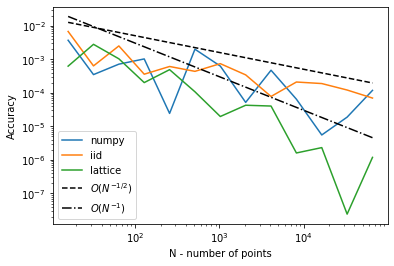

In [9]:
for name, results in vals.items():
    plt.loglog(num_posterior_draws_to_test, abs(results - reference_answer), label=name)
plt.loglog(num_posterior_draws_to_test, .05 * num_posterior_draws_to_test ** -.5, '--k', label='$O(N^{-1/2})$')
plt.loglog(num_posterior_draws_to_test, .3 * num_posterior_draws_to_test ** -1.0, '-.k', label='$O(N^{-1})$')
plt.xlabel('N - number of points')
plt.ylabel('Accuracy')
plt.legend(loc='lower left');

This is very similar to what the FB paper talked about and I think exactly the kind of thing we should be emphasizing in our discussions in a potential blog post which talks about BO applications of QMC.

Such a blog post is something that I would be happy to write up, by the way.